In [149]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('features_Z140Hep.csv')


## Datan esikäsittely 

In [150]:
# Valitaan sarakkeet, jotka sisältävät diagnoosit
diagnosis_columns = [
    'LE_MentalHealthDiagnosis1', 
    'LE_MentalHealthDiagnosis2', 
    'LE_MentalHealthDiagnosisOther',
    'CME_MentalHealthDiagnosis1',
    'CME_MentalHealthDiagnosis2',
    'CME_MentalHealthDiagnosisOther'
]

# Käytä One-Hot-koodausta valittuihin sarakkeisiin
diagnosis_data = data[diagnosis_columns]

# Täytetään tyhjät kohdat tyhjillä riveillä koodausvirheiden välttämiseksi
diagnosis_data = diagnosis_data.fillna('Unknown')

# One-Hot-koodauksen käyttäminen
encoded_diagnosis_data = pd.get_dummies(diagnosis_data, prefix=diagnosis_columns)

# Yhdistetään koodatut tiedot alkuperäiseen datajoukoon
data_with_encoded_diagnosis = pd.concat([data, encoded_diagnosis_data], axis=1)

# Poistetaan vanhat sarakkeet, joissa on diagnoosit
data_with_encoded_diagnosis = data_with_encoded_diagnosis.drop(columns=diagnosis_columns)

# data_with_encoded_diagnosis

In [151]:
# Suodatetaan vain numeeriset ominaisuudet klusterointia varten
data = data_with_encoded_diagnosis.select_dtypes(exclude='object')

# Poista kaikki sarakkeet, joiden nimessä on ”Unknown”, ”Unspecified” tai ”Unstated”, koska ne eivät sisällä vaikuttavia tietoja
keywords_to_remove = ['Unknown', 'Unspecified', 'Unstated', 'SuicideNote']
data = data.drop(columns=[col for col in data.columns if any(keyword in col for keyword in keywords_to_remove)])

# Korvataan Boolen arvot arvoilla 1 ja 0
df = data.apply(lambda x: x.map(lambda y: 1 if y == True else 0))

# Tarkistetaan mitä saattiin tuloksena
df

,MentalHealthProblem,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,AlcoholProblem,SubstanceAbuseOther,OtherAddiction,HistorySelfHarm,...,CME_MentalHealthDiagnosisOther_Social anxiety,CME_MentalHealthDiagnosisOther_Social anxiety disorder,CME_MentalHealthDiagnosisOther_Social phobia,CME_MentalHealthDiagnosisOther_Sociopathy,CME_MentalHealthDiagnosisOther_Suicidal ideation,CME_MentalHealthDiagnosisOther_Suicidal ideations,CME_MentalHealthDiagnosisOther_Suicidal ideations and drug induced psychosis,CME_MentalHealthDiagnosisOther_Suicide ideation,CME_MentalHealthDiagnosisOther_Suicide ideations,CME_MentalHealthDiagnosisOther_Tourette syndrome
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0,1,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3996,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Количество признаков в данных на данный момент 361. Это слишком много. Используем метод `Feature Selection` на основе вариативности (`Variance Threshold`).
Этот метод позволяет исключить признаки, которые имеют низкую вариативность (другими словами почти не изменяются в данных). Это простой способ уменьшить количество признаков, не полагаясь на целевые значения.

In [152]:
from sklearn.feature_selection import VarianceThreshold

# Устанавливаем порог для минимальной вариативности 0.01
selector = VarianceThreshold(threshold=0.01)

# Применяем селектор к данным
df_reduced = selector.fit_transform(df)

# Получаем маску выбранных признаков
mask = selector.get_support()

# Фильтруем исходные названия столбцов на основе маски
selected_columns = df.columns[mask]

# Создаем новый DataFrame с отобранными признаками и сохраняем их названия
df = pd.DataFrame(df_reduced, columns=selected_columns)

df

,MentalHealthProblem,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,AlcoholProblem,SubstanceAbuseOther,HistorySelfHarm,TreatmentNonAdherence,...,CME_MentalHealthDiagnosis1_Bipolar disorder,CME_MentalHealthDiagnosis1_Depression/dysthymia,"CME_MentalHealthDiagnosis1_Other (specify in diagnosis text), including personality disorders, etc.",CME_MentalHealthDiagnosis1_Schizophrenia,CME_MentalHealthDiagnosis2_Anxiety disorder,CME_MentalHealthDiagnosis2_Attention Deficit/Hyperactivity Disorder (ADHD),CME_MentalHealthDiagnosis2_Bipolar disorder,CME_MentalHealthDiagnosis2_Depression/dysthymia,"CME_MentalHealthDiagnosis2_Other (specify in diagnosis text), including personality disorders, etc.",CME_MentalHealthDiagnosis2_Post-traumatic stress disorder
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0,1,1,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3996,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Mallinnus

Выполним кластеризацию по методу `K-means` для выявления групп схожих пациентов и оценим важность признаков для каждой группы.

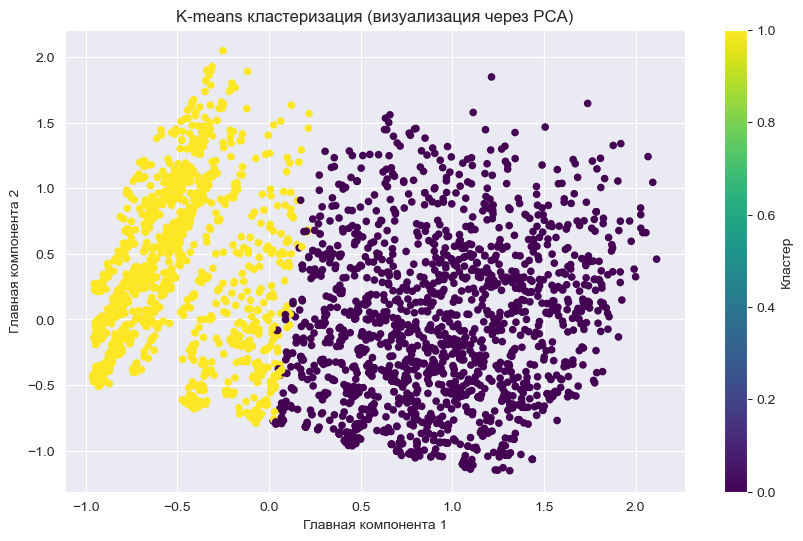

In [153]:
# Применяем PCA для уменьшения размерности до 2D для визуализации
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df)

# K-means кластеризация
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(df)

# Визуализация
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', s=20)
plt.colorbar(scatter, label='Кластер')
plt.title('K-means кластеризация (визуализация через PCA)')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True)
plt.show()

# Добавляем метки кластеров в исходный DataFrame
df['Cluster'] = kmeans.labels_

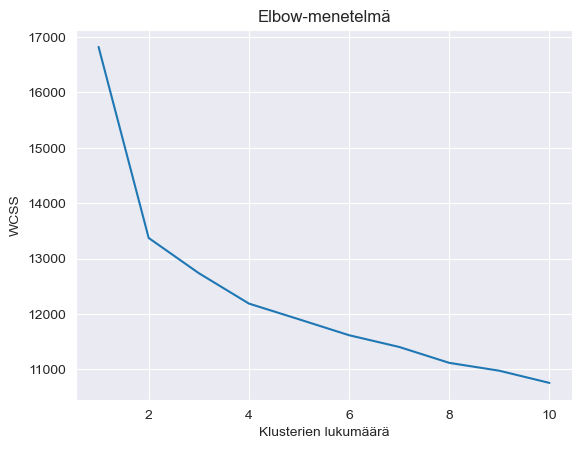

In [154]:
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):  # Tarkistetaan 1-10 klusteria
   kmeans = KMeans(n_clusters=i, random_state=42)
   kmeans.fit(df)
   wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Klusterien lukumäärä')
plt.ylabel('WCSS')
plt.title('Elbow-menetelmä')
plt.grid(True)
plt.show()

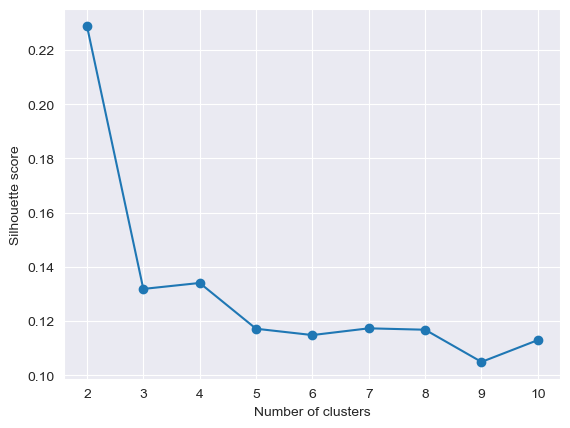

In [155]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    model = KMeans(n_clusters=i, random_state=42).fit(df)
    labels = model.labels_
    silhouette_scores.append(silhouette_score(df, labels))
    
# Visualisoidaan Silhouette score

plt.plot(range(2, 11), silhouette_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [156]:
# Lasketaan ominaisuuksien keskiarvot kullekin klusterille
cluster_means = df.groupby('Cluster').mean()

# Kustakin klusterista etsitään ominaisuudet, joiden keskiarvot ovat suurimmat
for cluster in cluster_means.index:
    print(f"\nKluster {cluster}:")
    # Etsetään 10 ominaisuutta, joilla on korkeimmat arvot tietyssä klusterissa
    top_features = cluster_means.loc[cluster].sort_values(ascending=False).head(10)
    print(top_features)




Kluster 0:
MentalHealthProblem                                0.991039
HistoryMentalIllnessTreatmnt                       0.835723
MentalIllnessTreatmentCurrnt                       0.611708
CME_MentalHealthDiagnosis1_Depression/dysthymia    0.610514
SuicideThoughtHistory                              0.593190
LE_MentalHealthDiagnosis1_Depression/dysthymia     0.448626
DepressedMood                                      0.382318
SuicideAttemptHistory                              0.372162
SuicideIntentDisclosed                             0.341099
IntimatePartnerProblem                             0.278973
Name: 0, dtype: float64

Kluster 1:
DepressedMood             0.288908
IntimatePartnerProblem    0.280310
SuicideThoughtHistory     0.277300
Argument                  0.227859
SuicideIntentDisclosed    0.226139
FamilyRelationship        0.147893
SubstanceAbuseOther       0.144884
MentalHealthProblem       0.124678
SchoolProblem             0.095873
SuicideAttemptHistory     0.092433
Na

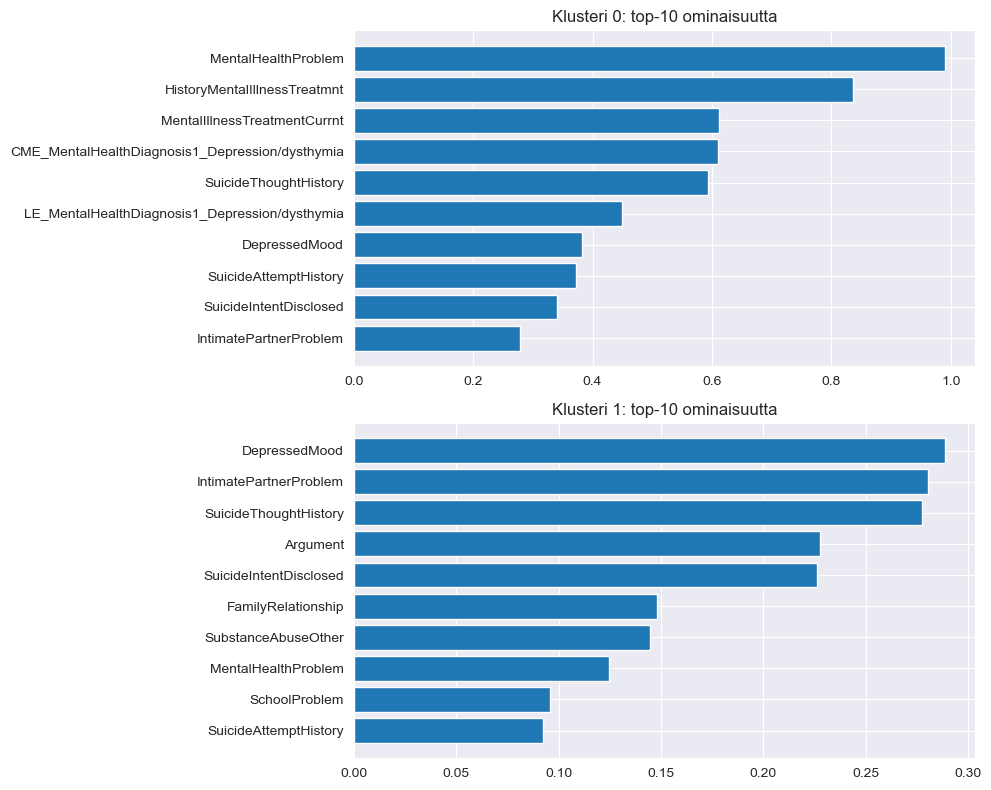

In [157]:
# Visualisoimme 10 ominaisuutta, joilla on korkeimmat painearvot kussakin klusterissa
fig, axs = plt.subplots(len(cluster_means.index), figsize=(10, 8))

for idx, cluster in enumerate(cluster_means.index):
    top_features = cluster_means.loc[cluster].sort_values(ascending=False).head(10)
    
    axs[idx].barh(top_features.index, top_features.values)
    axs[idx].set_title(f'Klusteri {cluster}: top-10 ominaisuutta')
    axs[idx].invert_yaxis()

plt.tight_layout()
plt.show()

### Klusterianalyysi ja johtopäätökset

#### Klusteri 0:
**Tärkeimmät ominaisuudet:**
1. **DepressedMood (masentunut mieliala)** — 28,88 %
2. **IntimatePartnerProblem (ongelmat läheisissä ihmissuhteissa)** — 27,93 %
3. **SuicideThoughtHistory (itsemurha-ajatusten historia)** — 27,71 %
4. **Argument (riidat, konfliktit)** — 22,77 %
5. **SuicideIntentDisclosed (itsemurha-aikeiden ilmaiseminen)** — 22,68 %


**Johtopäätökset:**
- Tässä klusterissa korostuvat masentunut mieliala, ihmissuhdeongelmat ja itsemurha-ajatukset. Lähes kolmanneksella on ollut itsemurha-ajatuksia, ja heistä monet ovat ilmaisseet aikomuksensa.
- **Ehkäisytoimenpiteet**: On tärkeää kiinnittää huomiota ihmisiin, joilla on masennusoireita ja ongelmia läheisissä ihmissuhteissa. Psykologisen tuen tarjoaminen ja konfliktinhallintataitojen opettaminen voivat auttaa ennaltaehkäisemään vakavampia ongelmia.

#### Klusteri 1:
**Tärkeimmät ominaisuudet:**
1. **MentalHealthProblem (mielenterveysongelmat)** — 99,16 %
2. **HistoryMentalIllnessTreatmnt (aiempi mielenterveyshoito)** — 83,61 %
3. **MentalIllnessTreatmentCurrnt (nykyinen mielenterveyshoito)** — 61,18 %
4. **Depression/Dysthymia (masennus/dystymia-diagnoosi)** — noin 61 %
5. **SuicideThoughtHistory (itsemurha-ajatusten historia)** — 59,39 %

**Johtopäätökset:**
- Lähes kaikilla tässä klusterissa olevilla on mielenterveysongelmia, ja suuri osa heistä on saanut tai saa parhaillaan hoitoa. Itsemurha-ajatuksia esiintyy monilla.
- **Ehkäisytoimenpiteet**: On välttämätöntä varmistaa jatkuva mielenterveyshoito ja seuranta. Koska monilla on diagnosoitu masennus tai dystymia, on tärkeää kiinnittää huomiota mielialan tasapainottamiseen ja itsemurha-ajatusten uusiutumisen ehkäisyyn.

#### Yhteenveto itsemurhien ehkäisemiseksi:
1. **Masennuksen ja dystymian hoito**: Molemmat klusterit osoittavat, että masennuksella on keskeinen rooli itsemurhariskeissä. Masennusta hoitavien lääkkeiden lisäksi tarvitaan terapeuttista tukea ja sosiaalisen verkoston vahvistamista.
   
2. **Ihmissuhdeongelmat**: Konfliktit parisuhteissa ja perheessä korostuvat, mikä viittaa siihen, että konfliktinratkaisutaidot ja vuorovaikutustaidot ovat tärkeitä.

3. **Varhaisten varoitusmerkkien tunnistaminen**: Itsemurha-ajatukset ja aikomusten ilmaiseminen ovat kriittisiä indikaattoreita. Läheisten on hyvä oppia tunnistamaan nämä merkit ja ohjaamaan apua tarvitsevat hoidon piiriin.

4. **Mielenterveyshoidon jatkaminen**: Niille, jotka ovat saaneet tai saavat hoitoa, on tärkeää varmistaa hoidon jatkuvuus ja säännöllinen seuranta. Tämä voi estää kriisitilanteiden syntymisen.



#### Yritetään ennustaa masennusta ja itsemurha-ajatuksia `Random Forest` - menetelmällä 

#### Itsemurhajan ajatuksia ennustaminen

In [158]:
df = df.drop(columns=['Cluster'])


In [159]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

target = 'SuicideThoughtHistory'

# Jaatetaan datajoukko
X = data.drop(columns=[target])
y = data[target]

In [160]:
# Jaatetaan tiedot oppi- ja testijoukoon
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
import numpy as np
from sklearn.model_selection import GridSearchCV
model_rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'bootstrap': [True],
    'criterion': ['gini'],
    'max_samples': [0.6, 0.7, 0.8],
    'max_features': [0.6, 0.7, 0.8],
    'random_state': [42]
}
# GridSearchCV
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=10, scoring='accuracy')

# Parametrien haku opettusjoukon avulla 
train_targets = np.ravel(y_train)
grid_search.fit(X_train, y_train)

# Parhaan mallin ja parametrit
best_model_rf = grid_search.best_estimator_
best_params_rf = grid_search.best_params_

print("Best Parameters:", best_params_rf)

Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 300, 'random_state': 42}


In [162]:
# Carry out 10-fold cross-validation
cv_scores = cross_val_score(best_model_rf, X_train, train_targets, cv=10)

# Tulokset
print(f'Fold-specific accuracies: {cv_scores}')
print(f'Overall accuracy (avg. of folds): {cv_scores.mean():.4f}')

Fold-specific accuracies: [0.715625 0.65625  0.70625  0.740625 0.71875  0.7125   0.75     0.69375
 0.725    0.703125]
Overall accuracy (avg. of folds): 0.7122


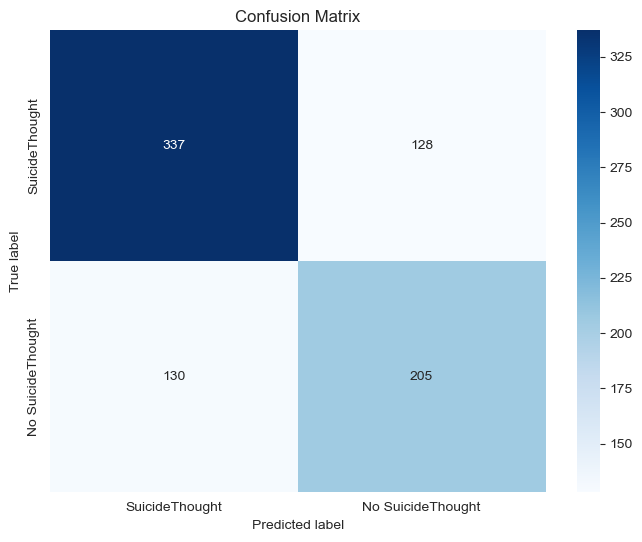

In [163]:
import seaborn as sns
predictions = best_model_rf.predict(X_test)

cm = confusion_matrix(y_test, predictions)
labels = ('SuicideThought', 'No SuicideThought')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [164]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       465
           1       0.62      0.61      0.61       335

    accuracy                           0.68       800
   macro avg       0.67      0.67      0.67       800
weighted avg       0.68      0.68      0.68       800



### Masennuksen ennustaminen

In [165]:
target = 'DepressedMood'

# Jaatetaan datajoukko
X = data.drop(columns=[target])
y = data[target]

In [166]:
# Jaatetaan tiedot oppi- ja testijoukoon
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [167]:
model_rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'bootstrap': [True],
    'criterion': ['gini'],
    'max_samples': [0.6, 0.7, 0.8],
    'max_features': [0.6, 0.7, 0.8],
    'random_state': [42]
}
# GridSearchCV
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=10, scoring='accuracy')

# Parametrien haku opettusjoukon avulla 
train_targets = np.ravel(y_train)
grid_search.fit(X_train, y_train)

# Parhaan mallin ja parametrit
best_model_rf = grid_search.best_estimator_
best_params_rf = grid_search.best_params_

print("Best Parameters:", best_params_rf)

Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 100, 'random_state': 42}


In [168]:
# Carry out 10-fold cross-validation
cv_scores = cross_val_score(best_model_rf, X_train, train_targets, cv=10)

# Tulokset
print(f'Fold-specific accuracies: {cv_scores}')
print(f'Overall accuracy (avg. of folds): {cv_scores.mean():.4f}')

Fold-specific accuracies: [0.70625  0.6875   0.640625 0.6375   0.64375  0.696875 0.7      0.65
 0.665625 0.696875]
Overall accuracy (avg. of folds): 0.6725


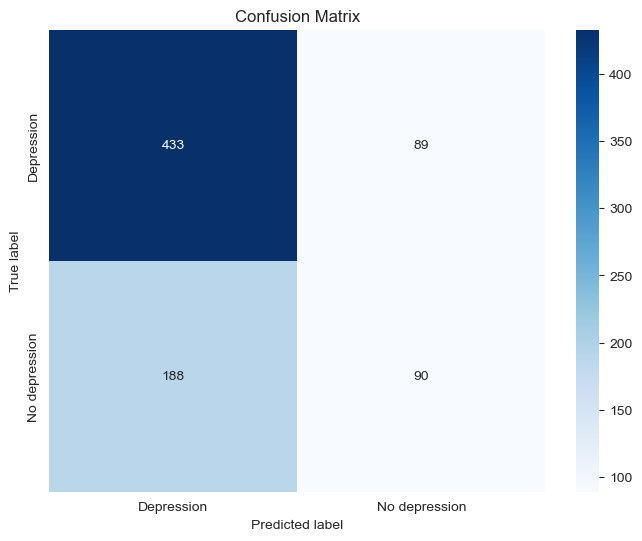

In [169]:
predictions = best_model_rf.predict(X_test)

cm = confusion_matrix(y_test, predictions)
labels = ('Depression', 'No depression')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [170]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       522
           1       0.50      0.32      0.39       278

    accuracy                           0.65       800
   macro avg       0.60      0.58      0.58       800
weighted avg       0.63      0.65      0.63       800

